In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch, PercentileInterval
from astropy.stats import mad_std
# import pyfftw.interfaces.numpy_fft as fft
fn = '../data/1551210093509O-result.csv' #stars in pi deg^2
dataset = Table.read(fn, )


In [2]:
%run ../code/nimsuv2.py

In [3]:
# you'll want to oversize the image and cut down later
# 7.86 fhwh
# 3.93
# 12.8 -> 13.8 micron spot size

jitter_1sigma = 0.3
psf_std = 7.86 / 2.355 #  fwhm to std
image_shape = (501, 501)
throughput = 0.8
QE = 0.5
arcsec_per_pixel = 3.93
target_mag = 21.

bg_star_magnitudes = dataset['phot_g_mean_mag']
rstate = 8675309

I = ImageSimulation(texp=2, lam=0.275, dlam=0.025, psf_oversample=30, image_shape=image_shape,
                    ncoadds=300, jitter=jitter_1sigma, psf_shape=[psf_std, psf_std, 0],
                    throughput=throughput, bg_star_magnitudes=bg_star_magnitudes, rstate=rstate,
                    target_mag=target_mag, arcsec_per_pixel=arcsec_per_pixel, QE=QE,
                    black=0.1, zodi=4.e-7)



In [4]:
science_img = I.make_science_image(rstate=rstate)
science_img_orig = np.copy(science_img)
ref_img = I.make_reference_image()

100%|██████████| 300/300 [3:28:11<00:00, 43.80s/it]  


In [5]:
kernel = Gaussian2DKernel(x_stddev=jitter_1sigma/I.arcsec_per_pix.value,
                          y_stddev=jitter_1sigma/I.arcsec_per_pix.value, mode='oversample', )
ref_img_conv = convolve_fft(ref_img, kernel, normalize_kernel=True)


# science_img_conv = convolve_fft(science_img_orig, kernel, normalize_kernel=True)
# science_img = science_img_conv

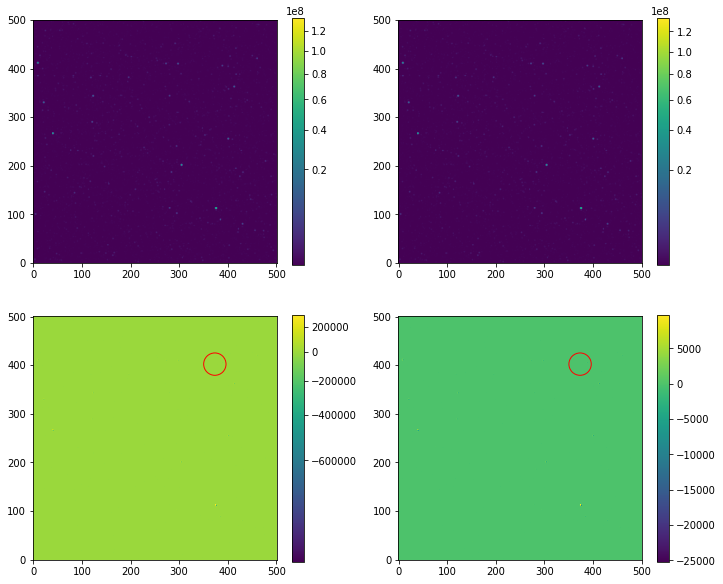

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,10])
ax = axes.flatten()[0]
# im = ax.imshow(bg_img, origin='lower', interpolation='nearest')
im, norm = imshow_norm(science_img, ax, origin='lower',
                       interval=MinMaxInterval(), stretch=SqrtStretch())
fig.colorbar(im, ax=ax)
####
ax = axes.flatten()[1]
# im = ax.imshow(bg_img_noiseless_conv, origin='lower', interpolation='nearest')
im, norm = imshow_norm(ref_img, ax, origin='lower',
                       interval=MinMaxInterval(), stretch=SqrtStretch())
fig.colorbar(im, ax=ax)
####
ax = axes.flatten()[2]
im, norm = imshow_norm(science_img - ref_img_conv, ax, origin='lower',
                       interval=MinMaxInterval(), stretch=SqrtStretch())
ax.scatter(I.table_targets['y_mean'][0], I.table_targets['x_mean'][0],
            marker='o', color='None', edgecolors='r', s=500)
fig.colorbar(im, ax=ax)
####
ax = axes.flatten()[3]
im, norm = imshow_norm((science_img - ref_img_conv) / mad_std(science_img - ref_img_conv),
                       ax, origin='lower',
                       interval=MinMaxInterval())
ax.scatter(I.table_targets['y_mean'][0], I.table_targets['x_mean'][0],
            marker='o', color='None', edgecolors='r', s=500)
fig.colorbar(im, ax=ax)

# fig.show(im)

(382.1170176851174, 422.1170176851174)

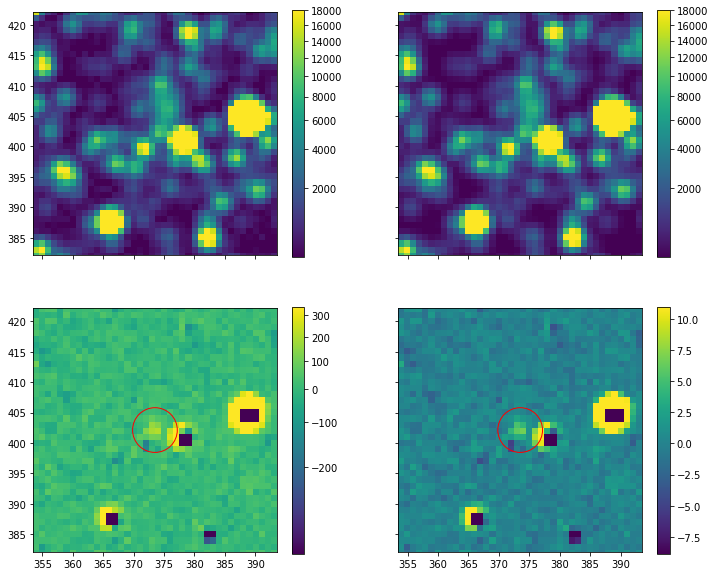

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,10], sharex=True, sharey=True)
ax = axes.flatten()[0]
# im = ax.imshow(bg_img, origin='lower', interpolation='nearest')
im, norm = imshow_norm(science_img, ax, origin='lower',
                       interval=PercentileInterval(90), stretch=SqrtStretch())
fig.colorbar(im, ax=ax)
####
ax = axes.flatten()[1]
# im = ax.imshow(bg_img_noiseless_conv, origin='lower', interpolation='nearest')
im, norm = imshow_norm(ref_img, ax, origin='lower',
                       interval=PercentileInterval(90), stretch=SqrtStretch())
fig.colorbar(im, ax=ax)
####
ax = axes.flatten()[2]
im, norm = imshow_norm(science_img - ref_img_conv, ax, origin='lower',
                       interval=PercentileInterval(98), stretch=SqrtStretch())
ax.scatter(I.table_targets['y_mean'][0], I.table_targets['x_mean'][0],
            marker='o', color='None', edgecolors='r', s=2000)
fig.colorbar(im, ax=ax)
####
ax = axes.flatten()[3]
im, norm = imshow_norm((science_img - ref_img_conv) / mad_std(science_img - ref_img_conv),
                       ax, origin='lower',
                       interval=PercentileInterval(98))
ax.scatter(I.table_targets['y_mean'][0], I.table_targets['x_mean'][0],
            marker='o', color='None', edgecolors='r', s=2000)
fig.colorbar(im, ax=ax)

ax.set_xlim(I.table_targets['y_mean'][0]-20, I.table_targets['y_mean'][0]+20)
ax.set_ylim(I.table_targets['x_mean'][0]-20, I.table_targets['x_mean'][0]+20)



In [8]:
ycut = np.round([I.table_targets['y_mean'][0]-3, I.table_targets['y_mean'][0]+3]).astype(int)
xcut = np.round([I.table_targets['x_mean'][0]-3, I.table_targets['x_mean'][0]+3]).astype(int)

xcutbig = np.round([I.table_targets['y_mean'][0]-20, I.table_targets['y_mean'][0]+20]).astype(int)
ycutbig = np.round([I.table_targets['y_mean'][0]-20, I.table_targets['y_mean'][0]+20]).astype(int)

diffim = (science_img[xcut[0]:xcut[1], ycut[0]:ycut[1]] - ref_img_conv[xcut[0]:xcut[1], ycut[0]:ycut[1]])
(diffim / np.std(science_img[xcutbig[0]:xcutbig[1], ycutbig[0]:ycutbig[1]] -
                       ref_img_conv[ycutbig[0]:ycutbig[1], ycutbig[0]:ycutbig[1]])).sum()

30.320381625900563

In [9]:
np.std(science_img[xcutbig[0]:xcutbig[1], ycutbig[0]:ycutbig[1]] -
                       ref_img_conv[ycutbig[0]:ycutbig[1], ycutbig[0]:ycutbig[1]])

68.2217516859704

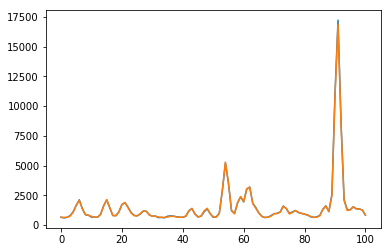

In [10]:
plt.plot(science_img[41])
plt.plot(ref_img[41])

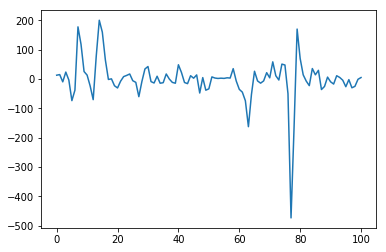

In [11]:
plt.plot(science_img[55] - ref_img[55])

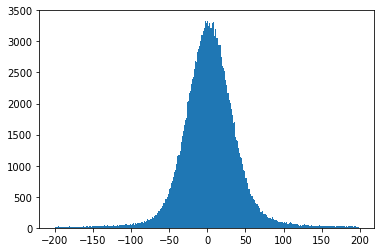

In [10]:
plt.hist((science_img - ref_img_conv).flatten(), np.arange(-200,200));

In [13]:
np.std(science_img - ref_img_conv)

336.5515327148222

In [11]:
I.table_bgstars

flux,x_mean,y_mean,x_stddev,y_stddev,theta
,,,,,rad
float64,float64,float64,float64,float64,float64
197.98562629722545,307.47850583183725,257.6686826453934,0.8492569002123143,0.8492569002123143,0.0
75.10216586116921,76.51177010308267,351.09286093899505,0.8492569002123143,0.8492569002123143,0.0
4.204710135416977,179.99595415248163,356.76594812455875,0.8492569002123143,0.8492569002123143,0.0
27.974199112659836,110.0713462230588,188.13112261040652,0.8492569002123143,0.8492569002123143,0.0
12.794675087755937,206.81381287811203,301.79003136086277,0.8492569002123143,0.8492569002123143,0.0
12.00288545917814,428.6112498249265,481.64083956484194,0.8492569002123143,0.8492569002123143,0.0
35.85819806507695,282.9477547233761,321.50876960782875,0.8492569002123143,0.8492569002123143,0.0
26.15686324269321,82.09183691939748,311.11329957854844,0.8492569002123143,0.8492569002123143,0.0


In [12]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.visualization import LinearStretch, LogStretch
from astropy.visualization import ZScaleInterval, MinMaxInterval
from astropy.visualization import ImageNormalize

palette = copy(plt.cm.gray)
palette.set_bad('r', 1.0)


import properimage.single_image as si
import properimage.propersubtract as ps

using pyfftw interfaces API


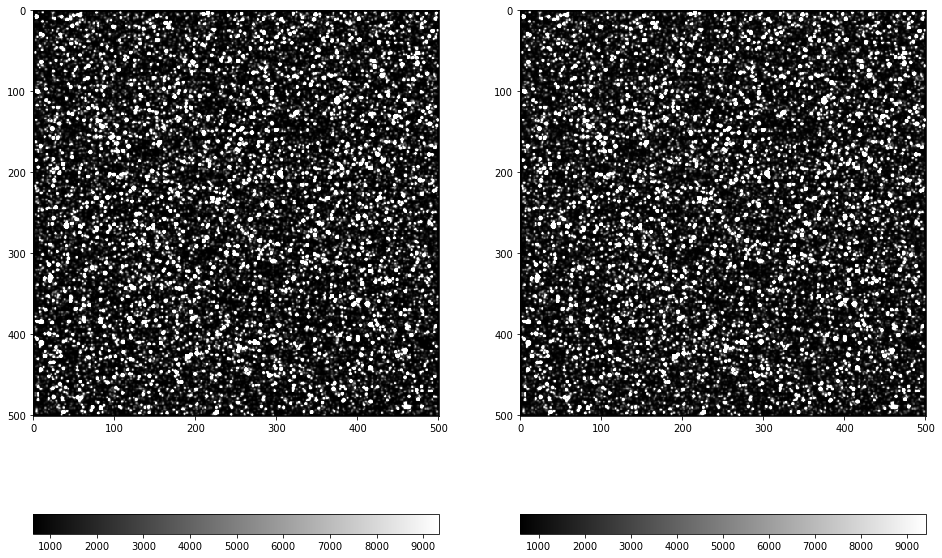

In [13]:
from astropy.io.fits import getdata

plt.figure(figsize=(16, 12))
plt.subplot(121)
ref = ref_img
norm = ImageNormalize(ref, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')

plt.subplot(122)
ref = science_img
norm = ImageNormalize(ref, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')

In [19]:
D, P, Scorr, mask = ps.diff(ref=ref_img, new=science_img,fitted_psf=True,
                            align=False, iterative=True, beta=True, shift=False)

using single psf, gaussian modeled
Sources found = 470
stamps will be 15 x 15
Sources found = 470
stamps will be 15 x 15
(470, 470, 470)
Matching result::  IDs > 0. => 452
p=2, q=453
[6.8423663  6.83802619]
('Masked pixels: ', 5471)
updating stamp shape to (21,21)


('Masked pixels: ', 5471)
updating stamp shape to (21,21)


Found that beta = 1.0004416051862457
Took only 0.0 awesome seconds
S_corr sigma_clipped_stats 
mean = -0.00011417132218525179, median = -8.936432331708007e-05, std = 0.0006022002471945261

Subtraction performed in 53.26086449623108 seconds




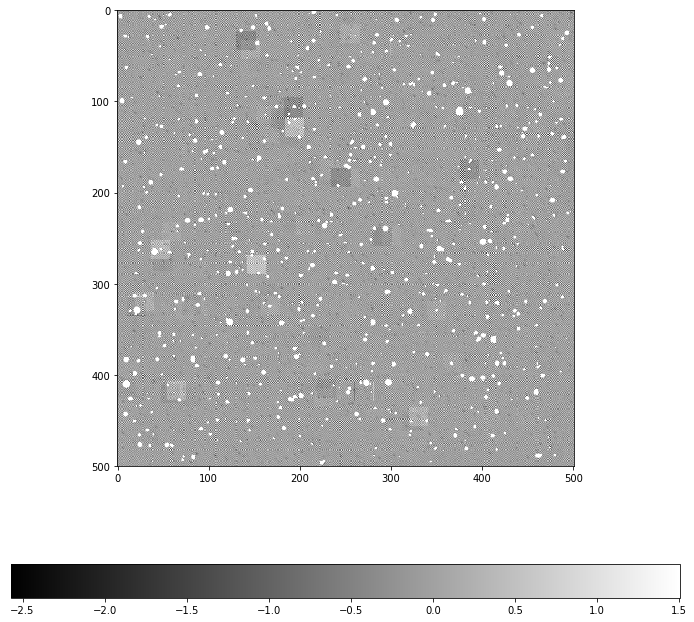

In [20]:
norm = ImageNormalize(D.real, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.figure(figsize=(12, 12))
plt.imshow(np.ma.MaskedArray(D.real, mask=mask),
           cmap=palette, norm=norm, interpolation='none')
plt.colorbar(orientation='horizontal')


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/matplotlib/image.py:863: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/matplotlib/image.py:865: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


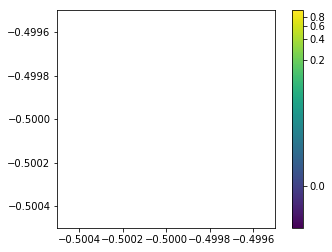

In [21]:

norm = ImageNormalize(P, interval=MinMaxInterval(),
                      stretch=LogStretch())
xc, yc = np.where(P==P.max())
xc, yc = np.round(xc[0]), np.round(yc[0])
plt.imshow(P[xc-10:xc+10, yc-10:yc+10], norm=norm,
           cmap='viridis', interpolation='none')
plt.colorbar()



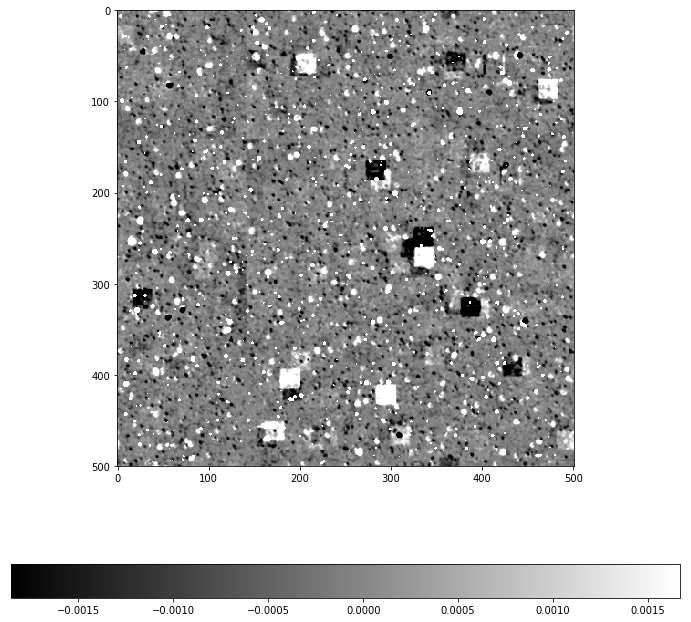

In [22]:
norm = ImageNormalize(Scorr.real, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.figure(figsize=(12, 12))
plt.imshow(np.ma.MaskedArray(Scorr.real, mask=mask),
           cmap=palette, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')


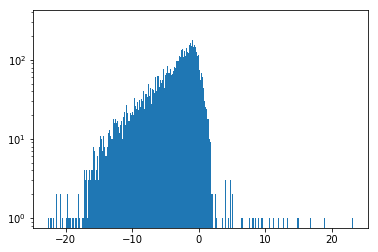

In [108]:
plt.hist(np.ma.MaskedArray(D.real, mask=mask).filled(0).flatten(), log=True, bins=500);
#plt.xlim(-10, 10)




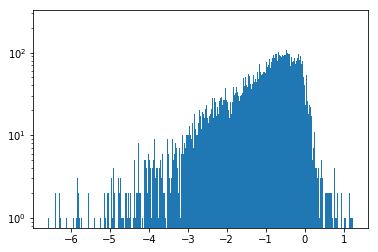

In [109]:
simage = np.ma.MaskedArray(Scorr.real, mask=mask).filled(0).flatten()
plt.hist(simage/np.std(simage), log=True, bins=500);
#plt.xlim(-4, 4)




In [ ]:
mad_std()